In [2]:
# Install YOLOv11 and necessary dependencies
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

In [3]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='8a1b95ea42f6c41ac024eae0d344b48f4b62a3f4')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bensghaierwaleed. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Define paths
root_dir = '/kaggle/input/cariesdetectionindian'
v1_dir = os.path.join(root_dir, '/kaggle/input/cariesdetectionindian')

In [5]:
# Ensure the YOLOv11 data directories exist
os.makedirs('yolov11/data/caries_v1', exist_ok=True)

Displaying some training images from version 1:


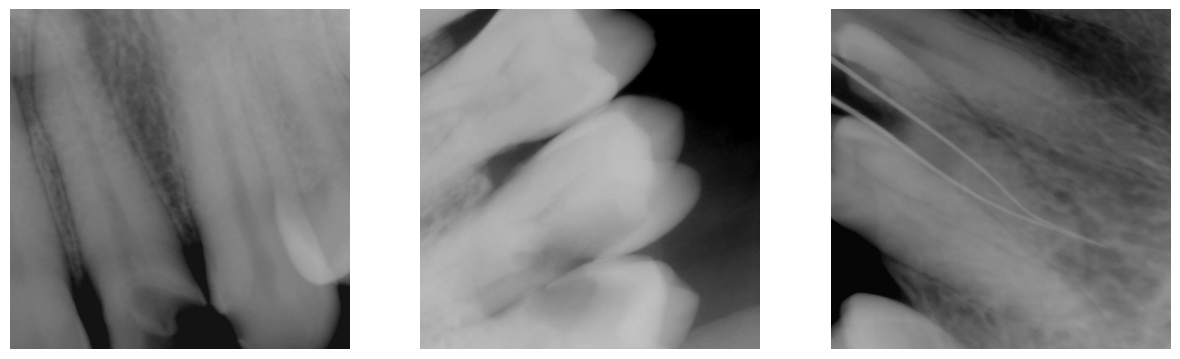

In [6]:
# Function to display images
def display_images(image_dir, num_images=3):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

In [7]:
# Copy dataset to YOLOv11 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov11/data/caries_v1')

In [8]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov11/data/caries_v1/data.yaml', '/kaggle/working/yolov11/data/caries_v1')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov11/data/caries_v1/data.yaml')



Updated data.yaml for version 1:
train: /kaggle/working/yolov11/data/caries_v1/train/images
val: /kaggle/working/yolov11/data/caries_v1/valid/images
test: /kaggle/working/yolov11/data/caries_v1/test/images


nc: 2
names: ['carries', 'deep carries']

roboflow:
  workspace: cropweed-ip5ij
  project: dheeraj-dentistry
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/cropweed-ip5ij/dheeraj-dentistry/dataset/1


In [9]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))


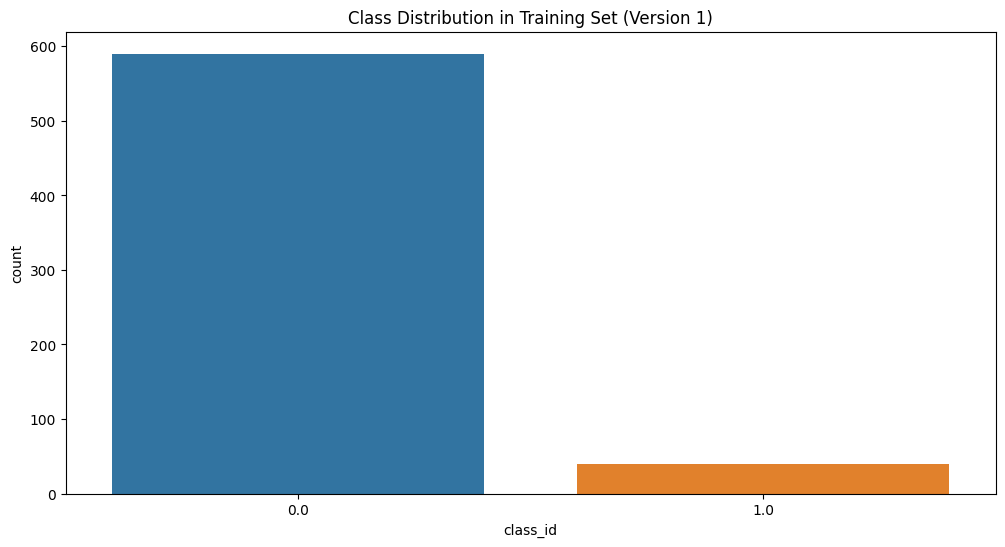

In [10]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

In [11]:
AUGMENTATION = False

if AUGMENTATION:
    augment_transform = Compose([
        HorizontalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        RandomBrightnessContrast(p=0.5),
        HueSaturationValue(p=0.5),
    ], bbox_params={'format': 'yolo', 'label_fields': ['labels']})

    def augment_images(destination_folder, minority_classes, num_aug=5):
        label_folder = os.path.join(destination_folder, 'labels')
        image_folder = os.path.join(destination_folder, 'images')

        for label_file in os.listdir(label_folder):
            label_path = os.path.join(label_folder, label_file)
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(image_folder, image_file)

            if not os.path.exists(image_path):
                continue

            # Đọc nhãn
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # Kiểm tra xem ảnh này có chứa lớp thiếu hay không
            contains_minority = False
            labels = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id = int(parts[0])
                if class_id in minority_classes:
                    contains_minority = True
                labels.append(parts)

            if not contains_minority:
                continue

            # Đọc ảnh
            image = cv2.imread(image_path)
            if image is None:
                continue

            # Chuyển đổi labels thành list of dicts cho albumentations
            bboxes = []
            bbox_labels = []
            for parts in labels:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                bboxes.append([x_center, y_center, width, height])
                bbox_labels.append(class_id)

            # Áp dụng augmentations và lưu lại
            for i in range(num_aug):
                augmented = augment_transform(image=image, bboxes=bboxes, labels=bbox_labels)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['labels']

                if not aug_bboxes:
                    continue  # Nếu không còn bounding boxes sau augmentation

                # Lưu ảnh đã augment
                aug_image_file = label_file.replace('.txt', f'_aug_{i}.jpg')
                aug_image_path = os.path.join(image_folder, aug_image_file)
                cv2.imwrite(aug_image_path, aug_image)

                # Chuyển đổi bounding boxes sang định dạng YOLO và ghi lại
                aug_label_file = label_file.replace('.txt', f'_aug_{i}.txt')
                aug_label_path = os.path.join(label_folder, aug_label_file)
                with open(aug_label_path, 'w') as f:
                    for bbox, cls_id in zip(aug_bboxes, aug_labels):
                        f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

        print("Data augmentation completed.")

    # Áp dụng augmentations cho các lớp thiếu
    threshold = 25000
    minority_classes = [cls for cls, count in train_class_count.items() if count < threshold]
    print("Minority Classes:", minority_classes)

    augment_images(train_folder, minority_classes, num_aug=5)

    # Tạo lại danh sách file sau khi augment
    train_image_files = os.listdir(os.path.join(train_folder, 'images'))
    train_label_files = os.listdir(os.path.join(train_folder, 'labels'))

    print(f"Train set after augmentation: {len(train_image_files)} images")

In [12]:
from ultralytics import YOLO
# Train YOLOv11 model with augmentation and hyperparameter tuning
# Initialize model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


In [13]:
# Train model on version 1 dataset
#AUGMENT = True
model.train(data='/kaggle/input/cariesdetectionindian/data.yaml',  # Path to dataset
epochs=200, 
    imgsz=640, 
    batch=16, 
    name='caries_v1_aug',
    lr0=0.0001,                   # Further reduced initial learning rate
    lrf=0.2,                     # Final learning rate scaling factor
    hsv_h=0.015,                 # Hue variation for augmentation
    hsv_s=0.7,                   # Saturation variation for augmentation
    hsv_v=0.4,                   # Value variation for augmentation
    degrees=0.0,                 # No rotation
    translate=0.1,               # Slight translation for generalization
    scale=0.6,                   # Scaling for small object variation
    shear=0.0,                   # No shear
    perspective=0.0,             # No perspective change
    flipud=0.2,                  # Vertical flip probability
    fliplr=0.5,                  # 50% chance for horizontal flip
    mosaic=0.65,                 # Slight increase in mosaic augmentation
    mixup=0.1,                   # Add light mixup for variability
    cls=1.2,                     # Adjusted class loss weight
    box=2.5,                     # Maintain current box loss weight
    save_period=3,               # Save checkpoint every 3 epochs
    verbose=True                 # Output true
)



Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/cariesdetectionindian/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=3, cache=False, device=None, workers=8, project=None, name=caries_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/cariesdetectionindian/train/labels... 842 images, 341 backgrounds, 0 corrupt: 100%|██████████| 842/842 [00:00<00:00, 894.87it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/cariesdetectionindian/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/cariesdetectionindian/valid/labels... 194 images, 80 backgrounds, 0 corrupt: 100%|██████████| 194/194 [00:00<00:00, 498.56it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/cariesdetectionindian/valid is not writeable, cache not saved.


Plotting labels to runs/detect/caries_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/caries_v1_aug
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.66G      0.827      12.71      2.433         10        640: 100%|██████████| 53/53 [00:13<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        194        134     0.0015      0.704    0.00732    0.00204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.67G     0.8248      11.37      2.409          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

                   all        194        134      0.564      0.036     0.0469      0.012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.66G     0.8157      9.935      2.327          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]

                   all        194        134     0.0893        0.1     0.0446     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.65G     0.8286      8.898      2.421          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


                   all        194        134      0.222      0.136     0.0636      0.015

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.66G     0.8208      8.296       2.44         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


                   all        194        134      0.101      0.072      0.061     0.0196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.65G     0.8392      7.922      2.373         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


                   all        194        134      0.518      0.164     0.0742     0.0269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.67G     0.8182      7.674      2.325          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


                   all        194        134      0.125      0.314     0.0985     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.66G     0.8192      7.426      2.366          5        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

                   all        194        134      0.168      0.268       0.12     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.66G     0.7845       7.12      2.335         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


                   all        194        134       0.23      0.279      0.162     0.0591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.65G     0.7831      6.792      2.352         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


                   all        194        134      0.201      0.358      0.136     0.0477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.66G     0.7795      6.856      2.241         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


                   all        194        134      0.216      0.235      0.191     0.0662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.65G     0.7805      6.877       2.29          4        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]

                   all        194        134     0.0998      0.186     0.0837     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.65G     0.7613      6.592       2.25          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]

                   all        194        134      0.249      0.363      0.197     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.65G     0.7496      6.518      2.212         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


                   all        194        134     0.0252      0.092     0.0738     0.0226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.66G     0.7473      6.683      2.231         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


                   all        194        134      0.213      0.339      0.189     0.0679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.65G     0.7495      6.553      2.223          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]

                   all        194        134      0.278      0.394      0.291      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.65G      0.756      6.257      2.232         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        194        134      0.289      0.462      0.303      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.66G     0.7463      6.441       2.23         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


                   all        194        134      0.325      0.298      0.287      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.66G      0.762      6.384      2.234         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


                   all        194        134      0.341      0.312      0.276     0.0954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.65G     0.7559       6.64      2.266         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


                   all        194        134       0.38      0.226      0.197     0.0796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.65G     0.7626       6.25      2.292         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]

                   all        194        134      0.412      0.573      0.359       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.65G     0.7538      6.264       2.22         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]

                   all        194        134      0.381      0.493      0.299     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.66G     0.7593       6.38      2.271         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


                   all        194        134      0.298      0.251      0.249      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.65G     0.7348      6.221      2.181          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


                   all        194        134      0.364       0.31      0.285      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.66G     0.7306      6.136       2.19         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]

                   all        194        134      0.213      0.371      0.185     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.65G     0.7259      6.096      2.197         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


                   all        194        134       0.25      0.585      0.281      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.67G     0.7263      6.073      2.207          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


                   all        194        134      0.413      0.583      0.407      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.67G     0.7162      6.019      2.167         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]

                   all        194        134      0.378      0.386      0.361       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.67G     0.7415      6.089      2.223          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]

                   all        194        134      0.328      0.414      0.395       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.65G     0.7424       6.09      2.154         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


                   all        194        134      0.479      0.358      0.341      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.66G     0.7361      6.068      2.199         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]

                   all        194        134      0.286      0.378      0.311      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.65G     0.7272      5.876      2.176         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


                   all        194        134      0.452      0.463      0.374      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.65G     0.7218      5.836      2.166          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


                   all        194        134      0.431      0.487      0.417      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.66G     0.7447      5.866      2.224         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]

                   all        194        134      0.379      0.473      0.397      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.66G     0.7411      5.777      2.179         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]

                   all        194        134      0.311      0.443      0.342      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.67G     0.7097      5.749      2.137         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


                   all        194        134      0.405      0.429      0.355       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.66G      0.715      5.815      2.198         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]

                   all        194        134      0.335      0.356      0.329      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.65G     0.7279      5.965      2.157         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


                   all        194        134      0.278      0.442      0.246     0.0754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.66G     0.7227      5.771      2.166         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


                   all        194        134      0.362      0.518       0.41      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.65G     0.7037      5.766      2.099         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


                   all        194        134      0.172      0.263      0.143     0.0477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.67G     0.7202      5.825      2.125          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        194        134      0.495      0.609      0.516      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.66G     0.7153      5.719       2.16         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.348      0.613      0.334      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.66G     0.7226       5.79      2.191         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


                   all        194        134      0.265      0.485      0.237     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.65G     0.7277       5.73      2.158         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]

                   all        194        134      0.211      0.255      0.147     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.65G     0.7171      5.627      2.096         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

                   all        194        134      0.361      0.443      0.421      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.65G     0.7026      5.714      2.108         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


                   all        194        134      0.421      0.482      0.438      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.68G     0.6977      5.513      2.073         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


                   all        194        134      0.371       0.57      0.406      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.66G     0.7072      5.622      2.115         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]

                   all        194        134      0.436      0.585      0.384      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.67G     0.7166      5.757      2.135          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


                   all        194        134       0.59      0.231      0.278      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.66G     0.7136      5.549       2.12         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]

                   all        194        134      0.427      0.462      0.431      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.67G     0.7063      5.476      2.086         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


                   all        194        134      0.444      0.533      0.458      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.65G     0.6972      5.517      2.104         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


                   all        194        134      0.422      0.502      0.493      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.67G     0.7078      5.387      2.077          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


                   all        194        134      0.581      0.608      0.587       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.65G     0.7047      5.416      2.078         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.458       0.45      0.426      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.66G     0.7084      5.491      2.082         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]

                   all        194        134      0.553      0.565      0.499      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.65G     0.6974      5.559      2.093         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]

                   all        194        134      0.641      0.485      0.579      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.67G     0.7008       5.33      2.076         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]

                   all        194        134      0.511      0.346      0.399      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.65G     0.6953      5.411      2.077          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]

                   all        194        134      0.488      0.515      0.462      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.66G      0.701      5.374       2.08          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]

                   all        194        134      0.675      0.558      0.637      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.67G     0.6988      5.414      2.075          4        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]

                   all        194        134      0.438      0.585      0.499        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.67G     0.7033      5.468      2.082         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


                   all        194        134      0.457      0.661      0.489      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.65G     0.6975       5.36      2.117          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]

                   all        194        134      0.664      0.436      0.571      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.66G     0.6927      5.196      2.079          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


                   all        194        134      0.452      0.585      0.504      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.66G     0.7126      5.228      2.121          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


                   all        194        134      0.379      0.513      0.435      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.65G      0.682      5.067       2.06          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


                   all        194        134      0.578       0.47      0.482      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.65G     0.6913      5.288      2.076          5        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]

                   all        194        134      0.564      0.419      0.554      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.66G     0.6898      5.184      2.047          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        194        134      0.633      0.589      0.616       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.65G     0.6954      5.172       2.03          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


                   all        194        134       0.65      0.645      0.621      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.65G     0.6913      5.073      2.064         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

                   all        194        134      0.296      0.483       0.35      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.66G     0.7072      5.316      2.088          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]

                   all        194        134      0.316      0.579      0.385      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.67G     0.6754      4.969      2.072         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]

                   all        194        134      0.342      0.486      0.498      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.65G     0.6796      4.996      2.016         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


                   all        194        134      0.626      0.534      0.538      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.66G     0.6793       5.02      2.053         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]

                   all        194        134      0.555      0.467      0.555      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.65G     0.6879      4.953      2.086         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]

                   all        194        134      0.657      0.592      0.648      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.66G     0.6781      5.034      2.045         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]

                   all        194        134      0.435      0.568      0.483      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.65G     0.6868      5.019      2.003         22        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]

                   all        194        134      0.539      0.605       0.55      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.66G     0.6684      4.882      2.004         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]

                   all        194        134      0.527      0.498      0.521      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.66G     0.6679      4.881      2.005         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


                   all        194        134      0.499      0.569      0.536       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.66G     0.6791       4.85      2.036         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134      0.465      0.514       0.52      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.65G     0.6767      4.919      2.007         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


                   all        194        134      0.462      0.581      0.479      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.65G     0.6807      4.964       2.02         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.523      0.523      0.534      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.66G     0.6861      4.965      2.045         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

                   all        194        134      0.494      0.727      0.637      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.67G     0.6875      4.877      2.041          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

                   all        194        134      0.531      0.552      0.501      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.66G       0.69      5.005      2.071         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]

                   all        194        134      0.672      0.477      0.598      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.66G     0.6632      4.947      2.016          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]

                   all        194        134      0.481      0.474      0.442      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.66G     0.6712      4.799      2.002          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]

                   all        194        134      0.545      0.546      0.539      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.66G     0.6951      4.965      2.068          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

                   all        194        134      0.579      0.574      0.572       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.65G     0.6713      4.861      2.031          4        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.609      0.644      0.668      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.67G     0.6792      4.872      2.026         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134       0.76      0.462      0.589      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.65G     0.6803      4.791      2.048         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


                   all        194        134      0.623      0.516      0.594      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.66G     0.6633      4.811      1.996         21        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


                   all        194        134      0.583       0.57      0.604      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.65G     0.6725      4.761      2.002         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]

                   all        194        134      0.637      0.629      0.659      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.65G     0.6603      4.717      1.988          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        194        134      0.599      0.451      0.596      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.65G      0.666      4.595          2          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


                   all        194        134      0.761      0.487      0.604       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.68G     0.6741      4.697      2.007         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


                   all        194        134      0.633      0.518      0.591      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.65G     0.6539      4.558      1.989          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        194        134       0.73      0.565       0.67      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.65G     0.6538      4.647      1.997         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]

                   all        194        134      0.479      0.427      0.455      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.67G     0.6393      4.325      1.946          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]

                   all        194        134       0.77       0.49       0.66      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.66G     0.6591      4.725      2.004         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

                   all        194        134      0.688      0.494      0.521      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.65G     0.6605      4.652      2.002          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]

                   all        194        134      0.509      0.657      0.542      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.65G     0.6792      4.624      2.019          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]

                   all        194        134      0.742      0.524      0.615      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.65G     0.6615      4.586      1.973         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]

                   all        194        134      0.477      0.642       0.62      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.66G      0.664      4.566      1.988          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


                   all        194        134      0.634      0.562      0.621      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.66G     0.6648      4.619      2.008         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

                   all        194        134      0.515      0.622      0.584      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.69G     0.6433      4.532      1.978          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

                   all        194        134      0.683      0.689       0.67        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.67G     0.6365      4.537      1.942         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]

                   all        194        134      0.648      0.561      0.635      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.66G     0.6498      4.699      1.975         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


                   all        194        134      0.651      0.613      0.615      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.65G     0.6497      4.557      1.973         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        194        134      0.494      0.625      0.567       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.65G     0.6488      4.478      1.978         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]

                   all        194        134      0.514      0.486      0.494      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.66G     0.6532      4.361      2.001         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]

                   all        194        134      0.556      0.561      0.623      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.66G     0.6438      4.452      1.974         23        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]

                   all        194        134      0.636      0.667      0.691      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.65G     0.6399      4.393       1.94         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


                   all        194        134      0.675      0.645      0.722       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.65G     0.6348      4.433      1.937          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]

                   all        194        134      0.744      0.565       0.67      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.65G     0.6341       4.35      1.919         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]

                   all        194        134      0.788      0.581      0.698      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.66G     0.6283      4.333      1.918         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

                   all        194        134      0.581      0.665      0.662      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.65G     0.6451      4.296      1.953          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134      0.573      0.569      0.652      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.67G     0.6443      4.499       1.99         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
    118/200      2.65G     0.6367      4.138      1.944         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]

                   all        194        134      0.691      0.674      0.688      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.66G     0.6469      4.331      1.963          5        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]

                   all        194        134      0.558      0.689      0.639      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.65G     0.6487      4.353      1.931          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        194        134       0.46      0.636      0.563      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.65G     0.6419      4.232      1.957          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]

                   all        194        134      0.748      0.621      0.753      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.66G     0.6332      4.219      1.925         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]

                   all        194        134      0.692      0.669      0.696      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.66G     0.6373      4.385      1.941         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]

                   all        194        134      0.722      0.673      0.727      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.66G      0.637      4.188      1.935          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.697      0.619      0.693       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.66G     0.6186      4.116      1.907         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]

                   all        194        134      0.677      0.673      0.703      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.65G     0.6281       4.15      1.897         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

                   all        194        134      0.754      0.653      0.739      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.67G      0.624      4.085      1.896         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]

                   all        194        134      0.658      0.629      0.706      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.67G       0.62      3.982      1.887         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]

                   all        194        134      0.696      0.681      0.718      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.65G     0.6468       4.17      1.959         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        194        134      0.566       0.76      0.725      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.65G     0.6275      4.304      1.951          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]

                   all        194        134      0.691      0.657      0.745      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.67G     0.6162      3.959      1.873         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]

                   all        194        134      0.793      0.575      0.686      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.65G     0.6114       4.11      1.862         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]

                   all        194        134      0.773      0.589      0.713      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.65G     0.6172      3.869      1.856         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]

                   all        194        134      0.729      0.614      0.714      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.65G     0.6131      3.906      1.863         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]

                   all        194        134      0.684      0.635      0.658      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.66G     0.6209      4.092      1.887         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        194        134      0.761      0.661      0.771      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.65G     0.6292      4.143      1.892         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        194        134      0.584      0.673       0.63      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.65G      0.618      4.168      1.902         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]

                   all        194        134      0.739      0.617      0.692      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.65G     0.6237      3.989      1.868         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]

                   all        194        134      0.559      0.665      0.627      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.66G     0.6313      4.048      1.907         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

                   all        194        134      0.784      0.646      0.738      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.66G     0.6034      3.987      1.853         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]

                   all        194        134      0.761      0.661      0.726      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.65G     0.6116      3.787      1.852          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

                   all        194        134      0.774      0.668      0.753      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.65G      0.623      4.086      1.882         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]

                   all        194        134      0.729      0.697      0.758      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.66G     0.5993       3.92       1.82          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        194        134      0.738      0.633      0.732      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.65G     0.6225      4.003      1.901          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]

                   all        194        134      0.727      0.625      0.728      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.65G     0.6156       4.03      1.869         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]

                   all        194        134      0.715      0.667      0.718      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.65G     0.6001      3.834      1.864         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]

                   all        194        134      0.711      0.677      0.766      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.66G     0.6136      3.858      1.855         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]

                   all        194        134      0.776      0.659      0.719      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.65G     0.6283      4.094      1.924          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]

                   all        194        134      0.845      0.605      0.764      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.65G     0.6043      3.734       1.85          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

                   all        194        134      0.715      0.665      0.737      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.65G     0.6231      3.869      1.885          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]

                   all        194        134      0.634      0.623      0.686      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.66G     0.6163      3.821      1.856         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134      0.722      0.651      0.676      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.65G     0.5879       3.81      1.829         10        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]


                   all        194        134      0.751      0.633      0.733      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.66G     0.6142      3.816      1.861         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        194        134      0.836      0.701      0.758      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.65G     0.6034      3.737      1.862          4        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

                   all        194        134      0.756      0.709      0.787      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.66G     0.6021      3.708      1.821         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]

                   all        194        134      0.716      0.667      0.771       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.67G     0.5992      3.809      1.848         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]

                   all        194        134      0.849      0.669      0.778      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.66G      0.602      3.767      1.842         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


                   all        194        134      0.791      0.661      0.777      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.65G     0.6008      3.721      1.836         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]

                   all        194        134      0.813        0.7       0.79      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.66G     0.5759      3.523      1.781         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

                   all        194        134      0.719      0.692      0.769      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.65G     0.6005      3.762       1.84         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134       0.78      0.637      0.742      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.65G     0.5897      3.583      1.808          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

                   all        194        134      0.738      0.681      0.772      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.65G     0.5813      3.603      1.775         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]

                   all        194        134      0.728      0.726      0.751      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.66G     0.5938      3.591      1.826          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        194        134      0.853      0.702      0.767      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.65G     0.5783      3.699      1.798         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]

                   all        194        134       0.71      0.752      0.809      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.67G     0.5763      3.612      1.793         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]

                   all        194        134      0.843      0.621      0.781      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.65G     0.5891      3.554      1.808          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]

                   all        194        134      0.719      0.737      0.725      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.66G     0.6016      3.721       1.86         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


                   all        194        134      0.668      0.701      0.636      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.65G     0.5824      3.565      1.822         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

                   all        194        134       0.75      0.677       0.72      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.67G     0.5729      3.455      1.799          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]

                   all        194        134      0.757      0.725      0.771      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.66G     0.5967       3.63      1.827         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        194        134      0.763      0.685      0.737      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.66G     0.5796      3.572      1.799         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


                   all        194        134      0.887      0.727      0.831      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.66G     0.5904      3.586       1.81         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

                   all        194        134      0.802      0.712      0.812      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.65G     0.5906      3.622      1.824         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        194        134      0.828      0.673      0.789      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.65G     0.5781      3.453      1.789         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]

                   all        194        134      0.767      0.699      0.793      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.66G      0.582      3.399      1.782         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]

                   all        194        134      0.713      0.655      0.746      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.66G     0.5803      3.589      1.773         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]

                   all        194        134      0.728      0.701      0.709      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.65G     0.5766      3.515      1.791          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

                   all        194        134      0.806      0.653      0.777      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.65G     0.5632      3.487      1.767          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

                   all        194        134      0.797      0.713      0.813      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.66G     0.5706      3.296      1.753         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        194        134      0.766      0.737       0.77      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.65G     0.5767      3.422      1.768         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


                   all        194        134      0.686      0.681      0.779      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.67G     0.5565       3.37      1.746          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]

                   all        194        134      0.879      0.681      0.785      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.65G     0.5626      3.287      1.739         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]

                   all        194        134      0.807      0.665      0.784      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.67G     0.5745      3.484      1.795         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

                   all        194        134      0.663      0.698      0.778      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.65G     0.5695      3.318      1.765         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]

                   all        194        134      0.712      0.723      0.806      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.65G     0.5893      3.355      1.797         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]

                   all        194        134      0.732      0.681      0.779      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.65G     0.5495      3.287      1.758         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]

                   all        194        134      0.729      0.739      0.806      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.66G     0.5831      3.433      1.791          4        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        194        134      0.725      0.677      0.796      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.65G     0.5698       3.45      1.785          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]

                   all        194        134      0.814      0.721      0.809      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.65G     0.5534      3.395      1.761          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]

                   all        194        134      0.733      0.729      0.795      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.65G     0.5718      3.299      1.766         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        194        134      0.857      0.709      0.778      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.66G     0.5252      2.807      1.733          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]

                   all        194        134      0.819      0.672      0.795       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.65G     0.5115      2.681      1.714         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]

                   all        194        134      0.764      0.701      0.792      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.65G      0.501      2.623      1.709          7        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        194        134       0.84      0.736        0.8      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.65G     0.5101      2.542      1.734          9        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]

                   all        194        134      0.689       0.74      0.751      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.66G     0.5202      2.606      1.715          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]

                   all        194        134       0.78      0.713      0.798      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.65G     0.5187      2.554      1.716          6        640: 100%|██████████| 53/53 [00:10<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.751      0.733      0.798       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.65G     0.5044      2.443      1.686          6        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]

                   all        194        134       0.75      0.721       0.81      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.65G     0.4973      2.533      1.681          4        640: 100%|██████████| 53/53 [00:10<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]

                   all        194        134      0.754      0.718      0.789      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.66G     0.4991      2.451      1.685          7        640: 100%|██████████| 53/53 [00:10<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]

                   all        194        134      0.765      0.717      0.791      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.67G     0.5094      2.488      1.697          3        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]

                   all        194        134      0.888      0.655      0.812      0.414



200 epochs completed in 0.722 hours.
Optimizer stripped from runs/detect/caries_v1_aug/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/caries_v1_aug/weights/best.pt, 5.5MB

Validating runs/detect/caries_v1_aug/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]


                   all        194        134      0.754      0.717      0.789      0.449
               carries        106        125      0.752      0.655      0.764      0.358
          deep carries          9          9      0.755      0.778      0.813      0.539


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/caries_v1_aug


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d771c3f70d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Displaying results from model trained on version 1 with augmentation:

image 1/1 /kaggle/input/cariesdetectionindian/test/images/aug_R1-802-_jpg.rf.58329588859f301d52b478b05a333e95.jpg: 640x640 (no detections), 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


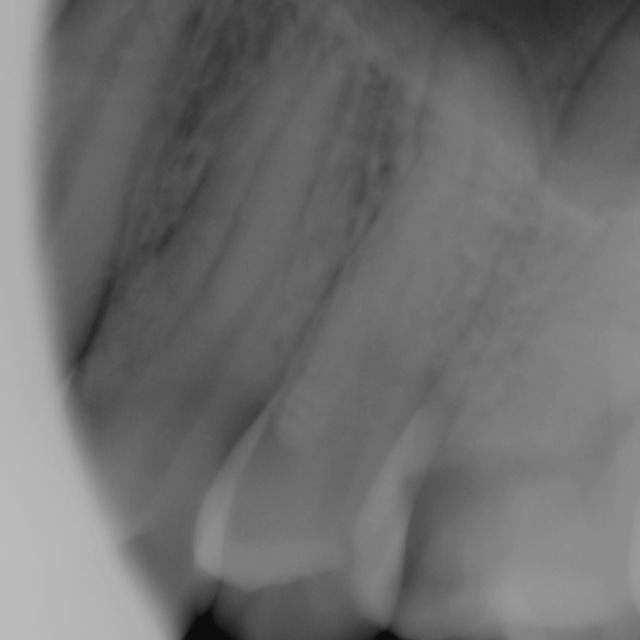


image 1/1 /kaggle/input/cariesdetectionindian/test/images/R1-474-_jpg.rf.1ef96d55a2a33c0137239831335355ab.jpg: 640x640 (no detections), 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


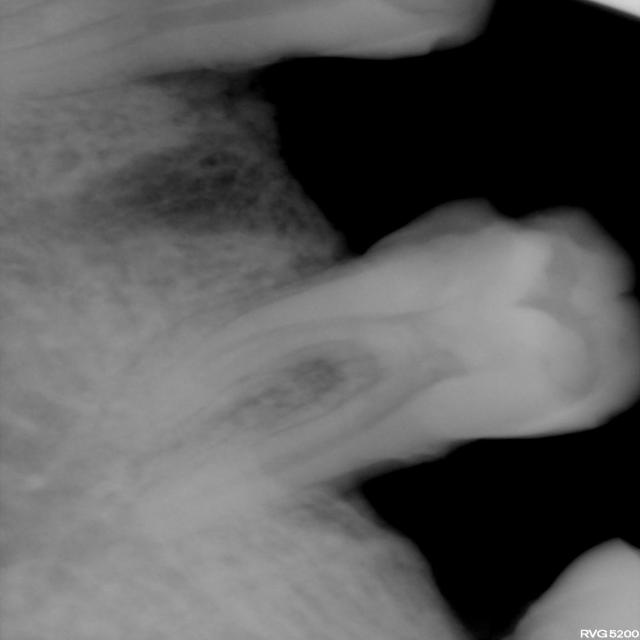


image 1/1 /kaggle/input/cariesdetectionindian/test/images/aug_R1-505-_jpg.rf.bc8113a0377464d393fa4a6955eaa95f.jpg: 640x640 2 carriess, 8.2ms
Speed: 1.4ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


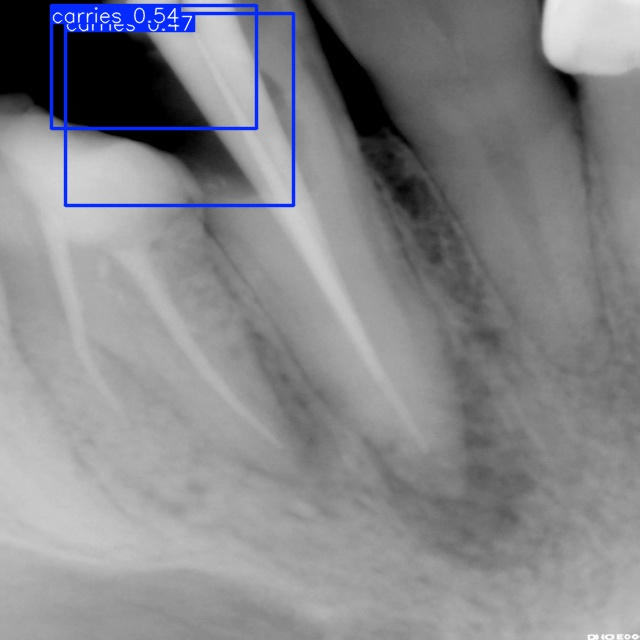


image 1/1 /kaggle/input/cariesdetectionindian/test/images/aug_R1-199-_jpg.rf.2d3c01ab68c3c1f7d85d7be47e4c62d6.jpg: 640x640 (no detections), 8.6ms
Speed: 1.4ms preprocess, 8.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


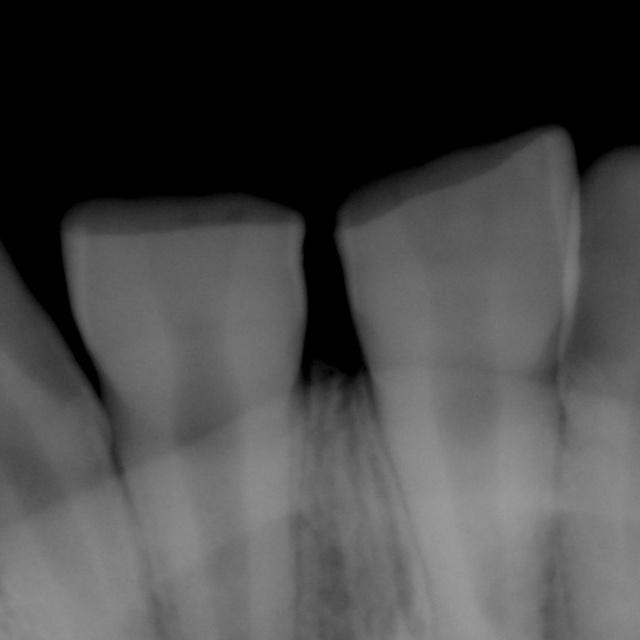


image 1/1 /kaggle/input/cariesdetectionindian/test/images/R1-883-_jpg.rf.73f3a164f7bddfa3c462067fdd4a7ab4.jpg: 640x640 1 carries, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


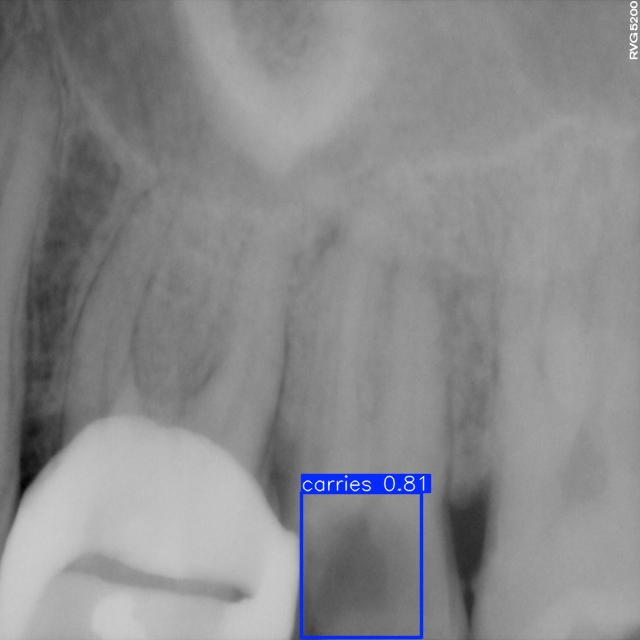

In [14]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model, os.path.join(v1_dir, 'test/images'))


In [15]:
!ls /kaggle/working/runs/detect/caries_v1_aug/

args.yaml					  train_batch10070.jpg
confusion_matrix_normalized.png			  train_batch10071.jpg
confusion_matrix.png				  train_batch10072.jpg
events.out.tfevents.1738061094.ef8d288f9e00.67.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


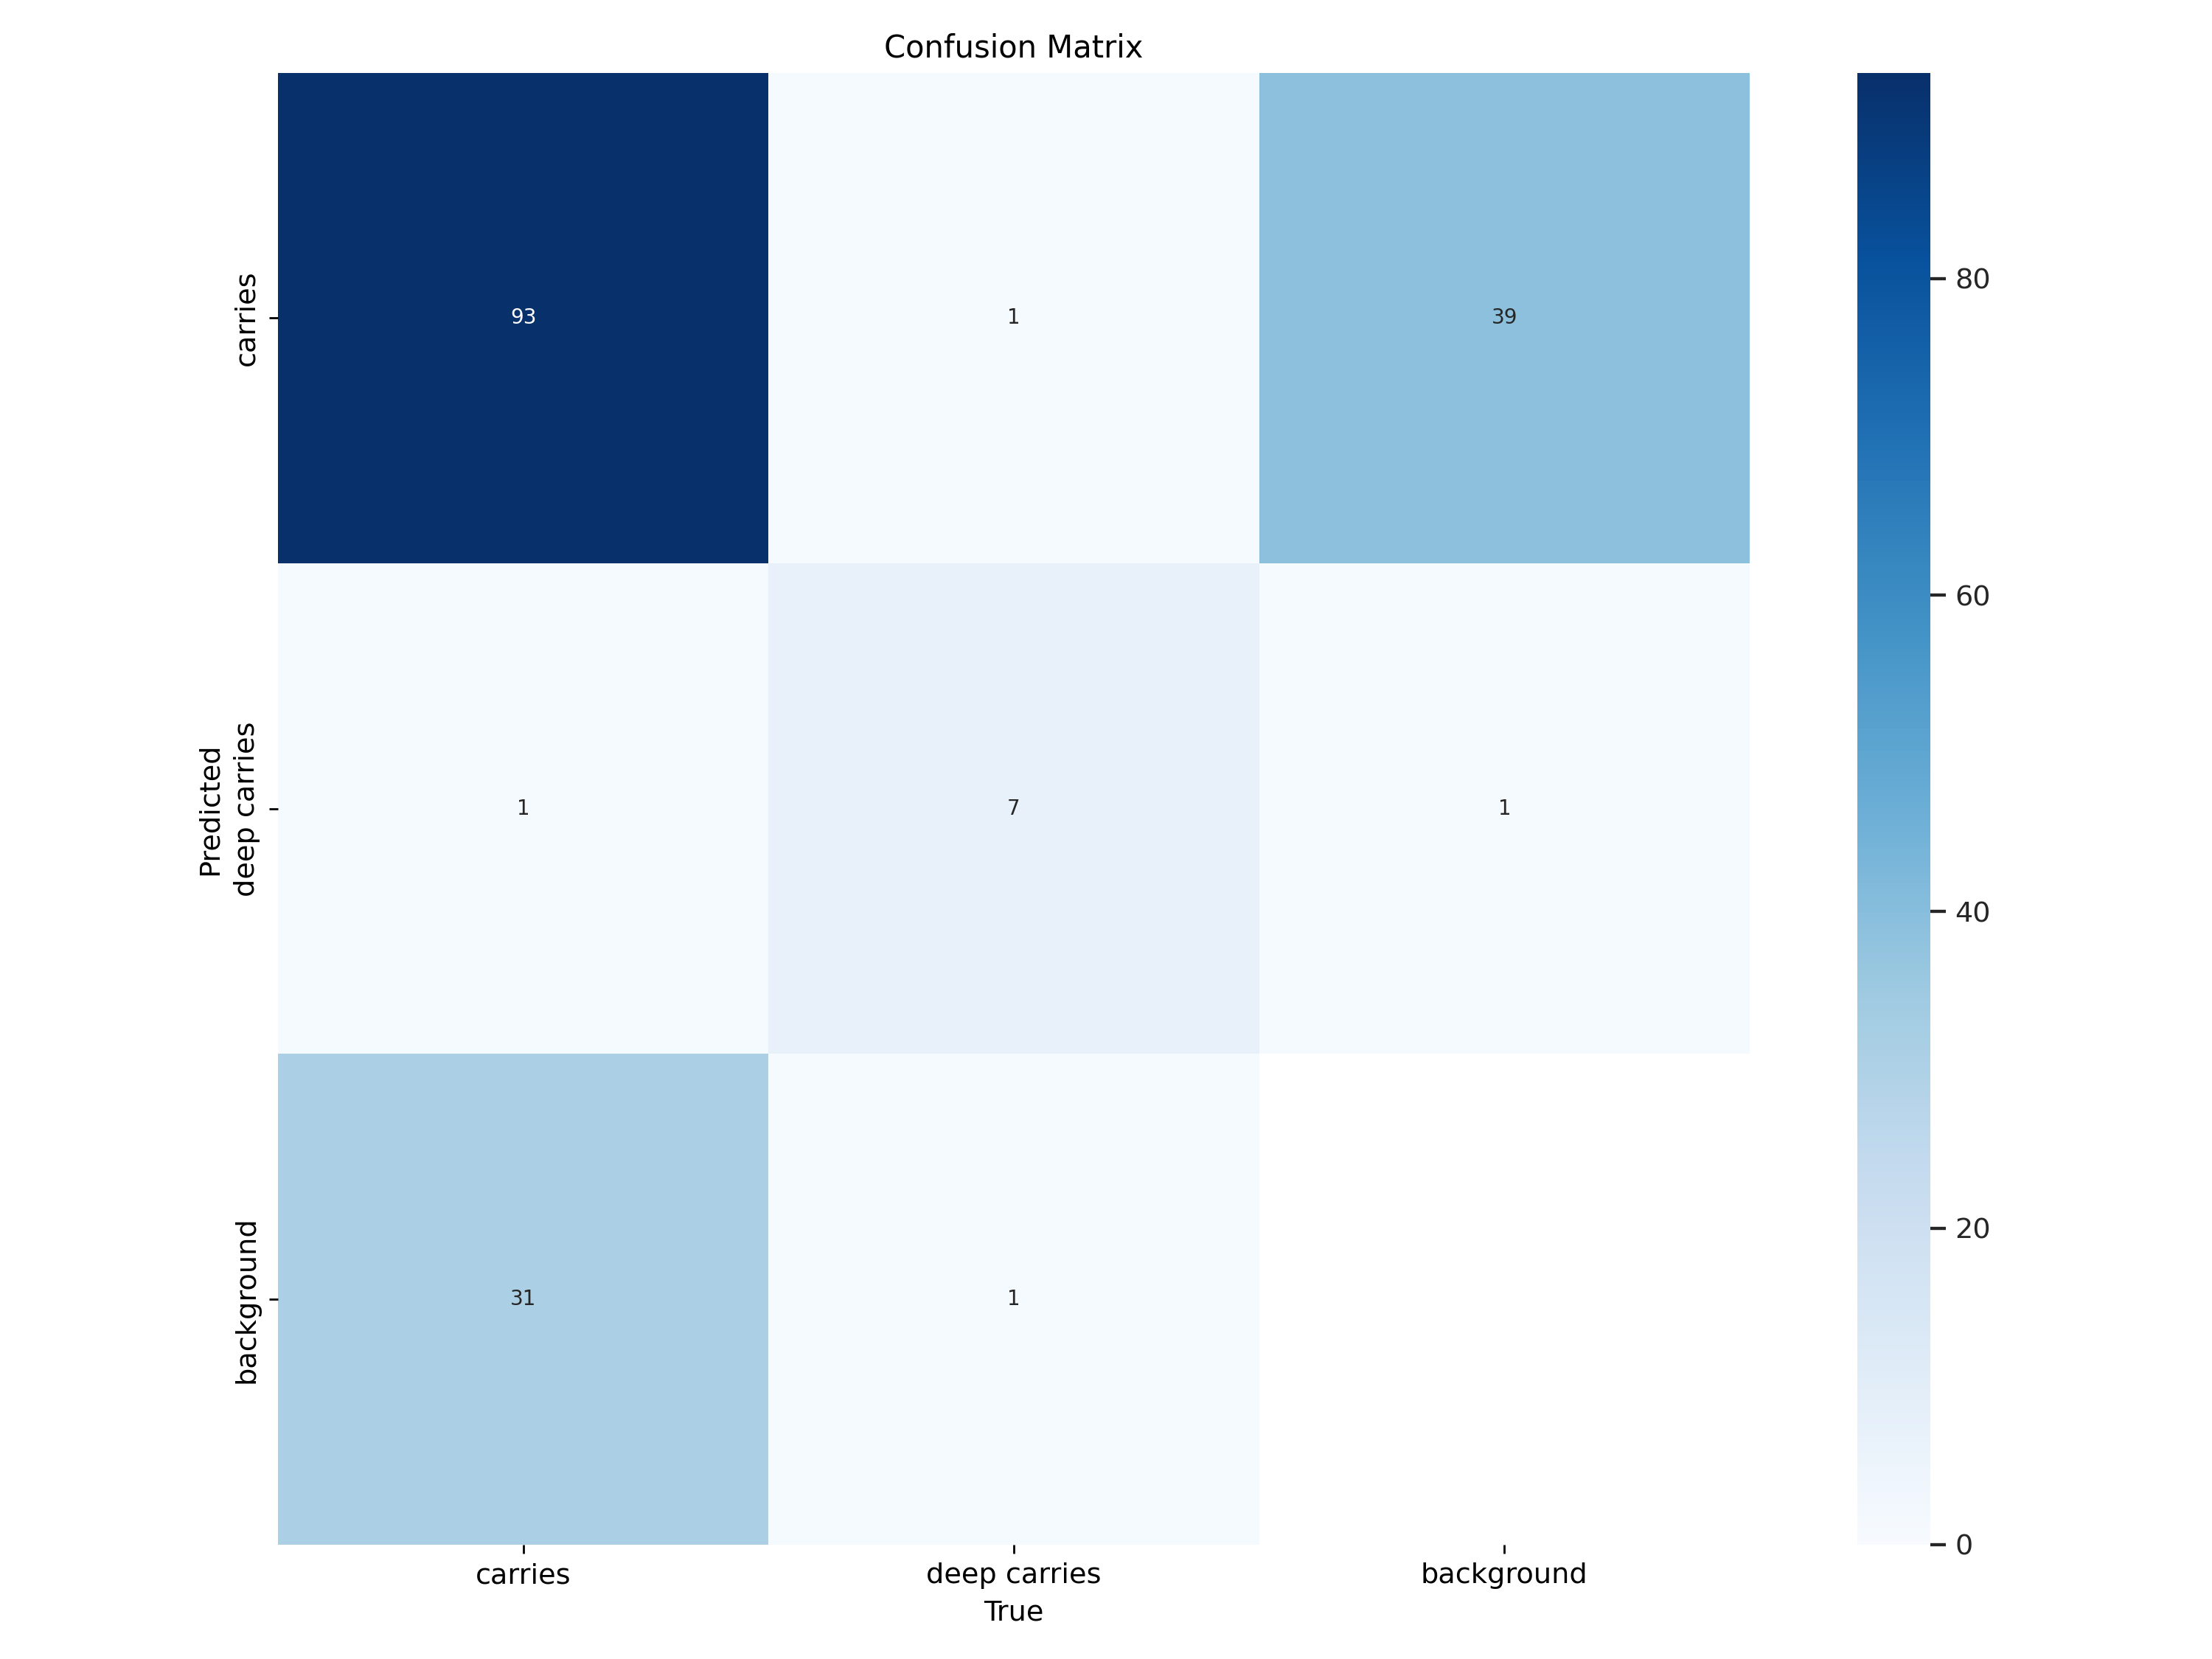

In [16]:
from IPython.display import Image as IPyImage

# Display the confusion matrix image from the specified directory in Kaggle
IPyImage(filename='/kaggle/working/runs/detect/caries_v1_aug/confusion_matrix.png', width=1000)


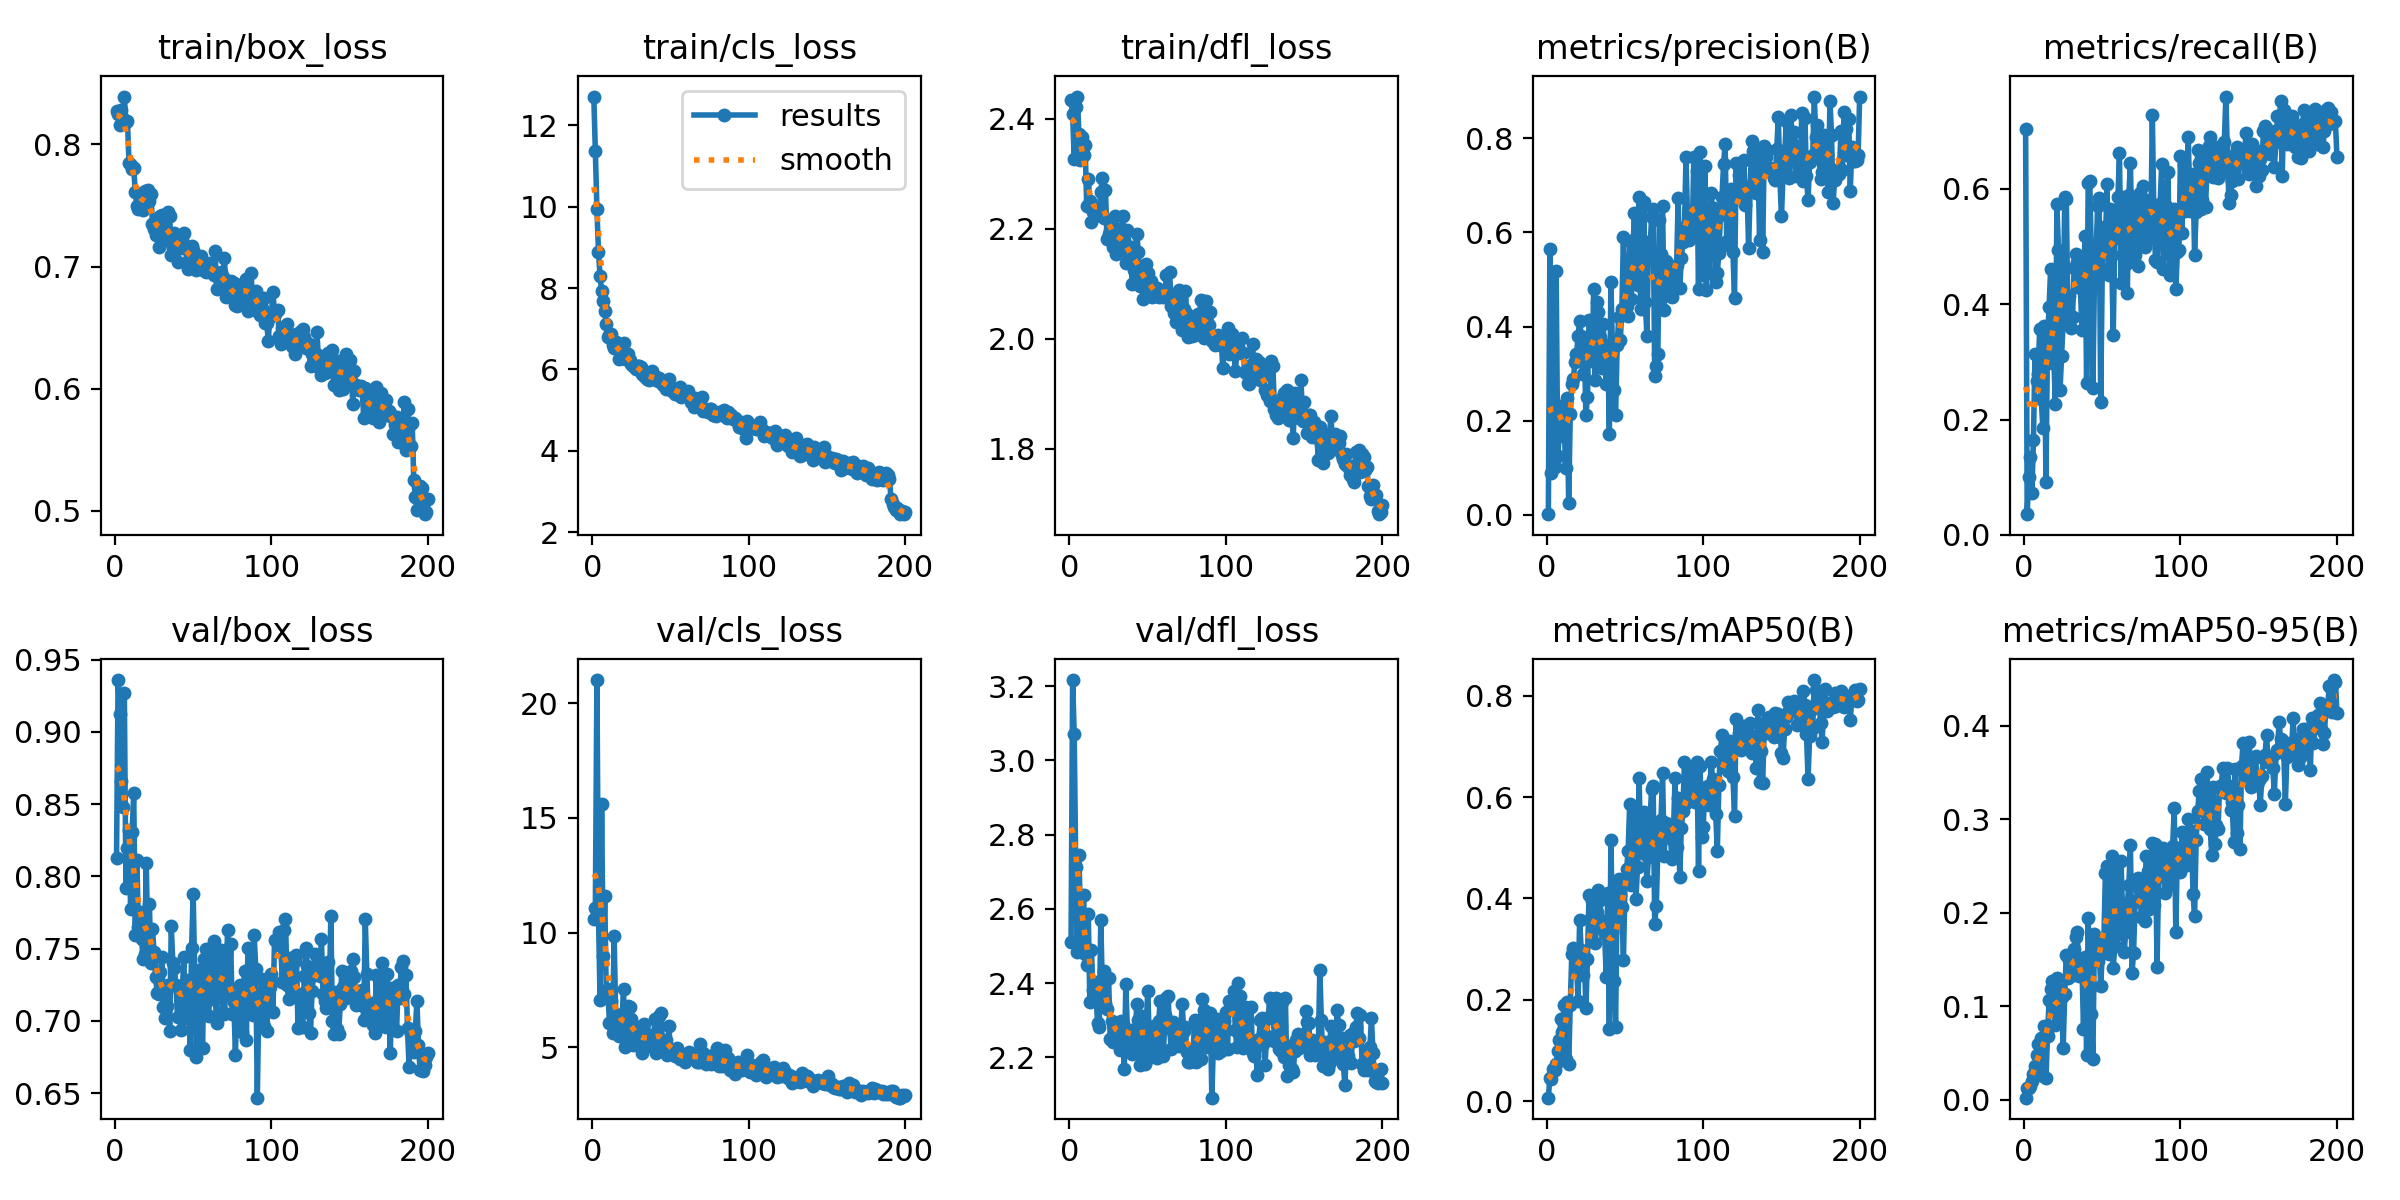

In [17]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/results.png', width=1000)

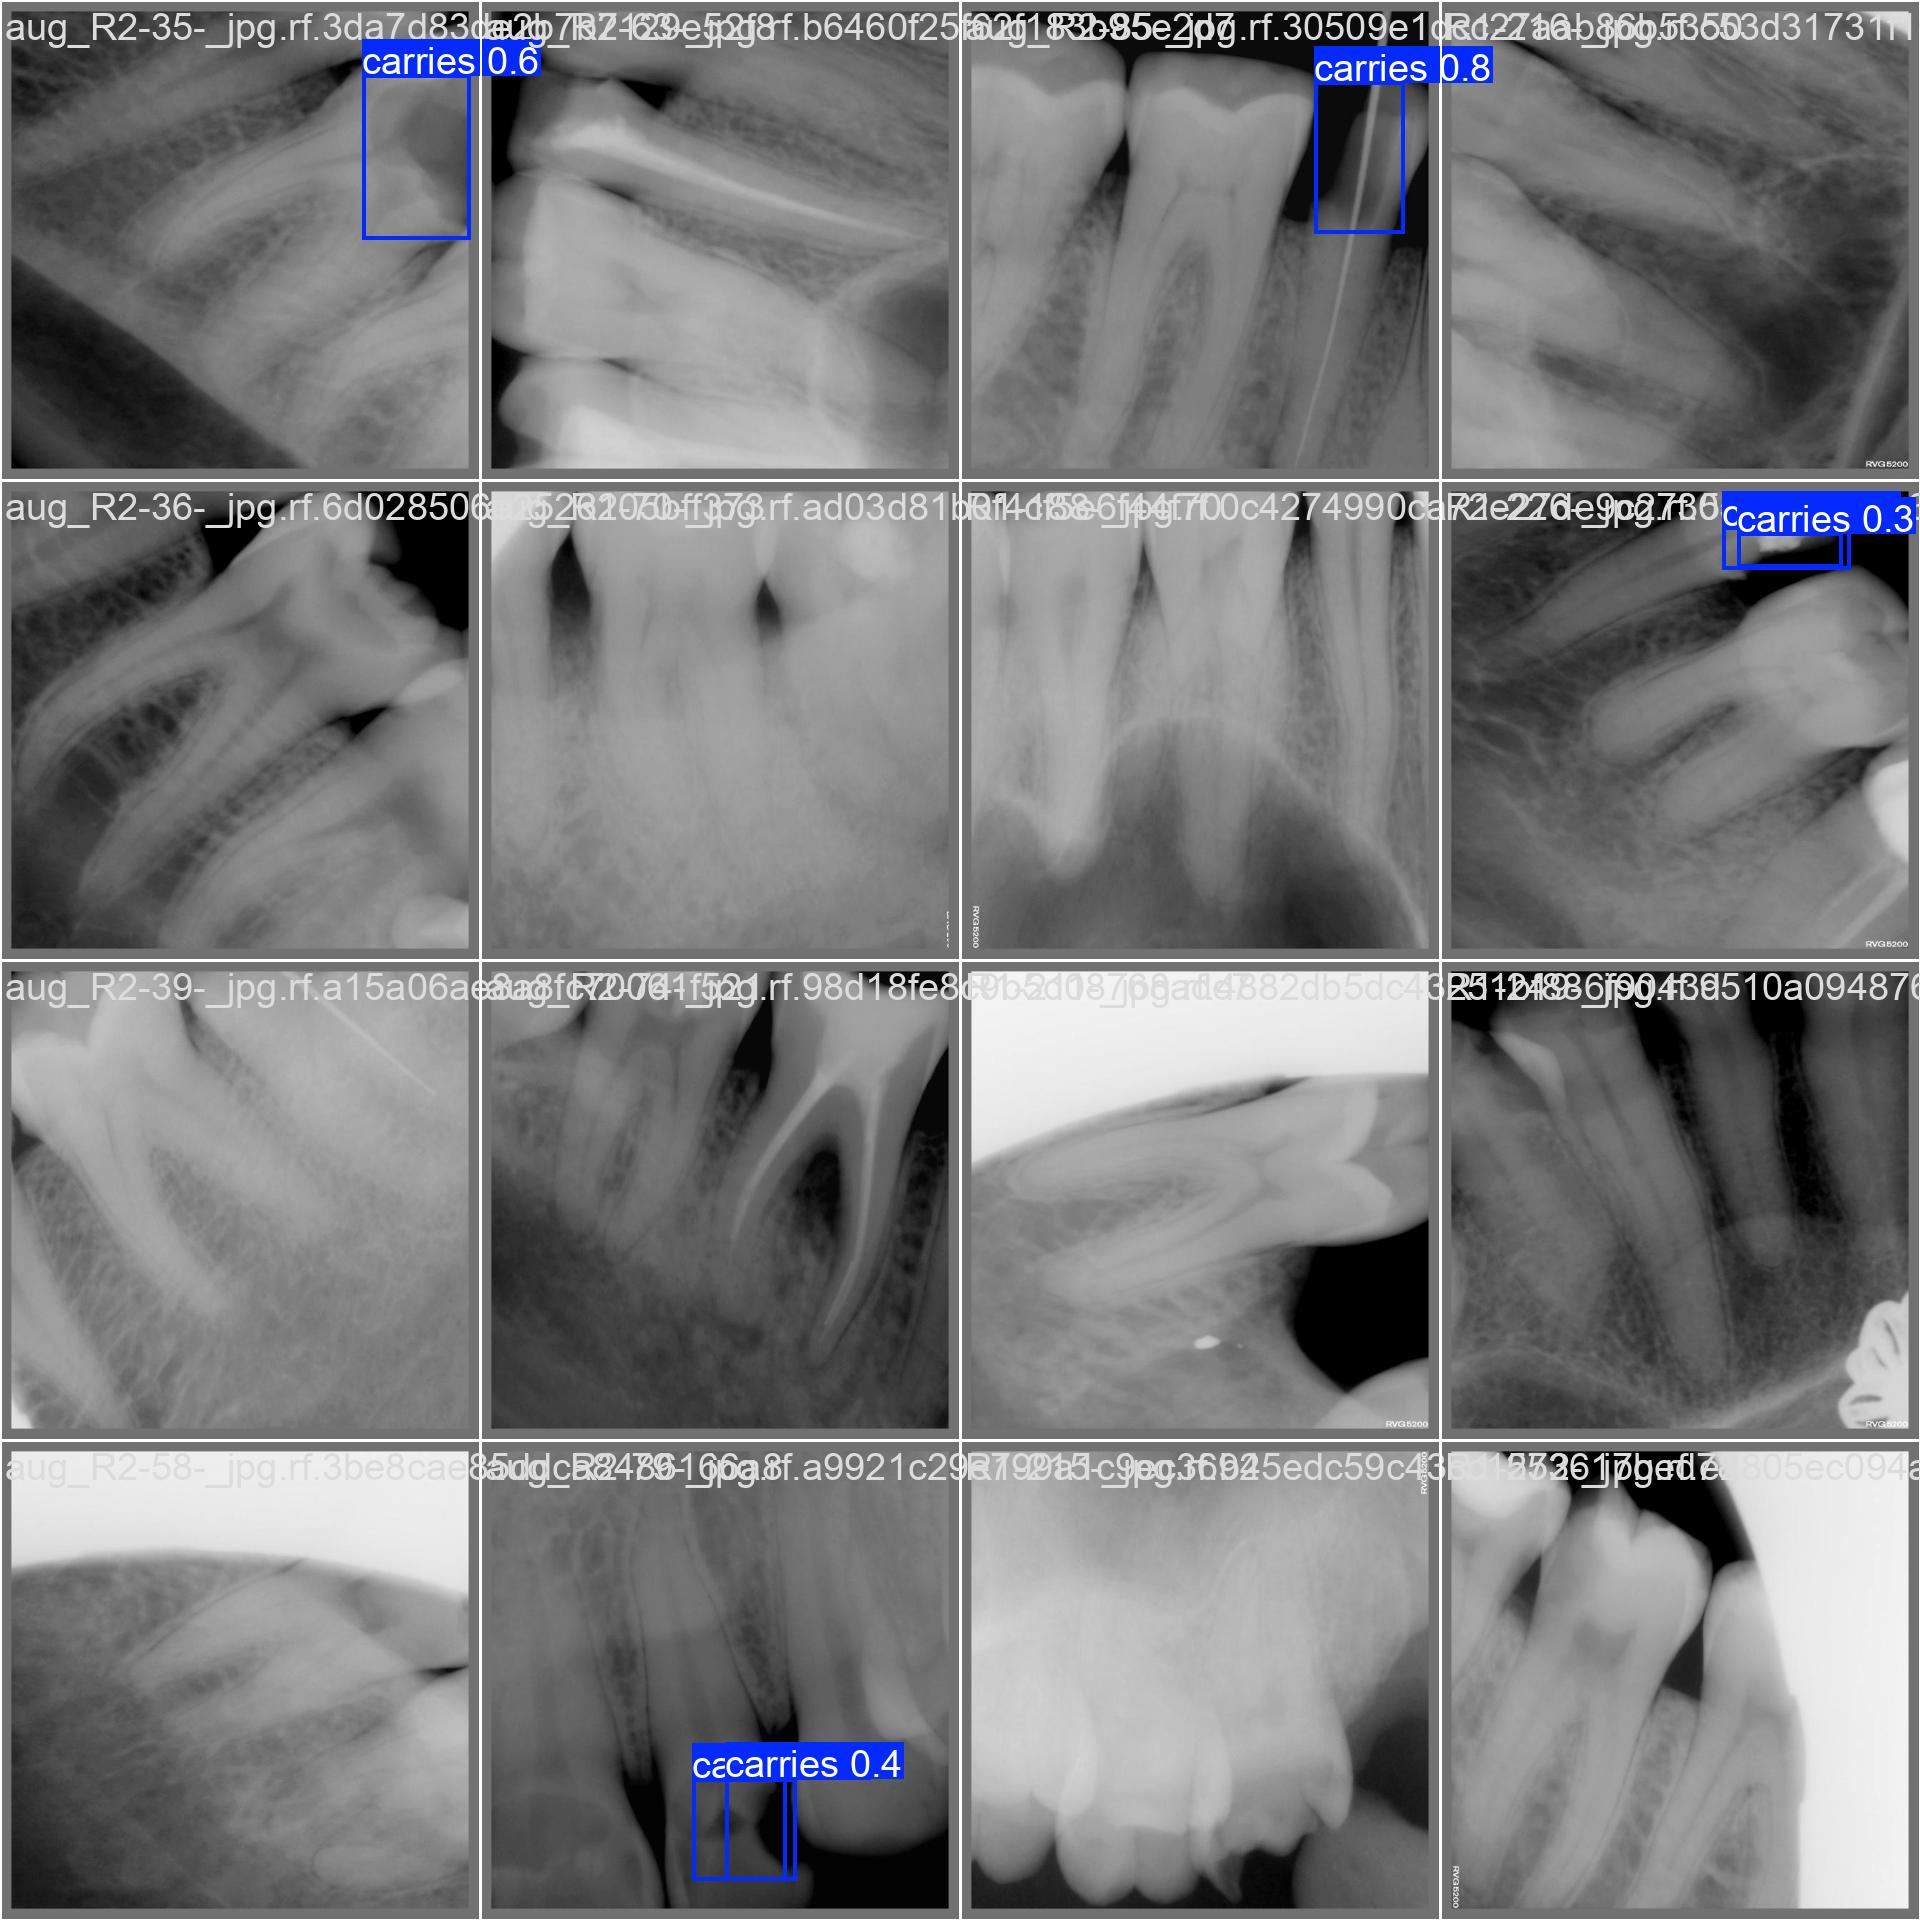

In [18]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/val_batch0_pred.jpg', width=1000)

In [19]:
# Run the validation task using YOLO in Kaggle
!yolo task=detect mode=val model=/kaggle/working/runs/detect/caries_v1_aug/weights/best.pt data=/kaggle/working/yolov11/data/caries_v1/data.yaml

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/working/yolov11/data/caries_v1/valid/labels... 194 images,
val: New cache created: /kaggle/working/yolov11/data/caries_v1/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        194        134      0.759      0.717      0.788      0.448
               carries        106        125      0.763      0.656      0.762      0.357
          deep carries          9          9      0.755      0.778      0.814      0.539
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 3.5ms inference, 0.

In [20]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
log_file_path = "/kaggle/working/runs/detect/caries_v1_aug/results.csv"
logs = pd.read_csv(log_file_path)  # Read log file into a DataFrame

final_losses = logs.iloc[-1]  # Get the last row

# Print final losses
print("Final Losses:")
print(f"Training Box Loss: {final_losses['train/box_loss']}")
print(f"Training Class Loss: {final_losses['train/cls_loss']}")
print(f"Training DFL Loss: {final_losses['train/dfl_loss']}")
print(f"Validation Box Loss: {final_losses['val/box_loss']}")
print(f"Validation Class Loss: {final_losses['val/cls_loss']}")
print(f"Validation DFL Loss: {final_losses['val/dfl_loss']}")

# Print additional metrics
print("\nFinal Metrics:")
print(f"Precision: {final_losses['metrics/precision(B)']}")
print(f"Recall: {final_losses['metrics/recall(B)']}")
print(f"mAP@50: {final_losses['metrics/mAP50(B)']}")
print(f"mAP@50-95: {final_losses['metrics/mAP50-95(B)']}")

Final Losses:
Training Box Loss: 0.50941
Training Class Loss: 2.48807
Training DFL Loss: 1.6972
Validation Box Loss: 0.67758
Validation Class Loss: 2.91605
Validation DFL Loss: 2.13097

Final Metrics:
Precision: 0.88839
Recall: 0.65528
mAP@50: 0.81225
mAP@50-95: 0.41359


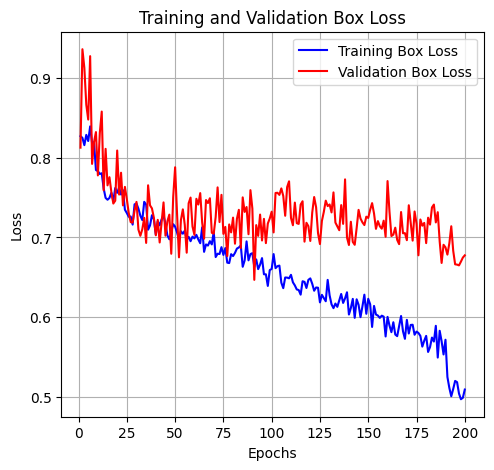

In [21]:
plt.figure(figsize=(12, 5))

# Plot training box loss
plt.subplot(1, 2, 1)
plt.plot(logs['epoch'], logs['train/box_loss'], label='Training Box Loss', color='blue')
plt.plot(logs['epoch'], logs['val/box_loss'], label='Validation Box Loss', color='red')
plt.title('Training and Validation Box Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [22]:
path="/kaggle/input/cariesdetectionindian/test/images/R1-295-_jpg.rf.3ee7cfea484a6db1d710c94649956b83.jpg"
#prediction on a single image
results = model.predict(source=path,show_labels=False)


image 1/1 /kaggle/input/cariesdetectionindian/test/images/R1-295-_jpg.rf.3ee7cfea484a6db1d710c94649956b83.jpg: 640x640 2 carriess, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


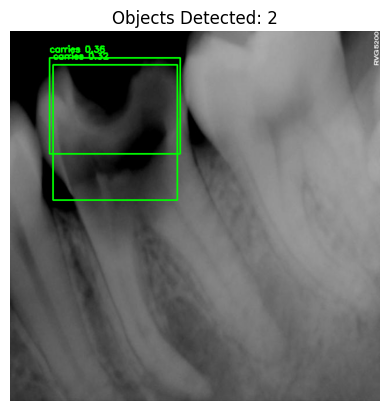

In [23]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(path)

# Loop through detection results
for result in results:
    boxes = result.boxes  # Get the bounding boxes
    for box in boxes:
        # Extract bounding box coordinates, confidence, and class id
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        conf = box.conf[0].item()
        cls = box.cls[0].item()
        
        # Generate label with class name and confidence
        label = f'{model.names[int(cls)]} {conf:.2f}'
        
        # Draw bounding box and label on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)  # Green text above the box

# Convert BGR image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.title(f"Objects Detected: {len(boxes)}")
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [24]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 115 (delta 13), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (115/115), 41.00 MiB | 43.55 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [ ]:
!ls

runs  yolo11n.pt  yolov11  YOLO-V8-CAM


In [ ]:
%cd /kaggle/working/YOLO-V8-CAM

/kaggle/working/YOLO-V8-CAM


In [ ]:
!pip install ttach

In [ ]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [ ]:
img = cv2.imread('/kaggle/input/cariesdetectionindian/test/images/R1-295-_jpg.rf.3ee7cfea484a6db1d710c94649956b83.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [ ]:
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
    

In [ ]:
target_layers =[model.model.model[-4]]

In [ ]:
cam = EigenCAM(model, target_layers,task='od')


0: 640x640 2 carriess, 151.2ms
Speed: 4.7ms preprocess, 151.2ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 640)


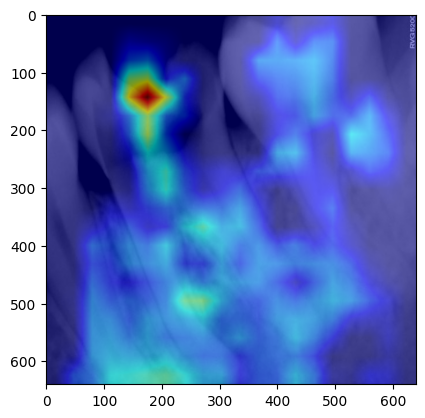

In [ ]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [ ]:
target_layers =[model.model.model[-3]]


0: 640x640 2 carriess, 90.7ms
Speed: 2.6ms preprocess, 90.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


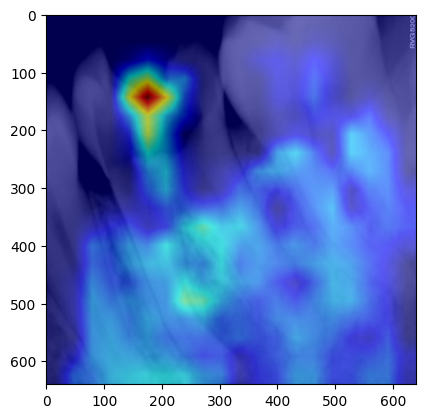

In [ ]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [ ]:
target_layers =[model.model.model[-4]]



0: 640x640 2 carriess, 99.8ms
Speed: 2.9ms preprocess, 99.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


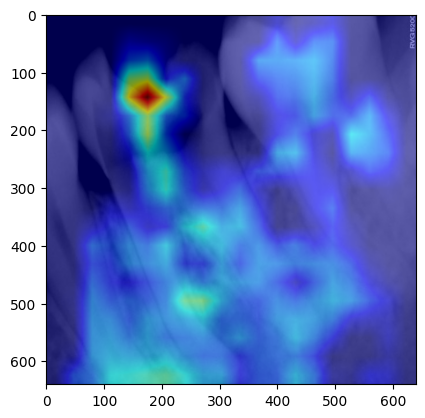

In [ ]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

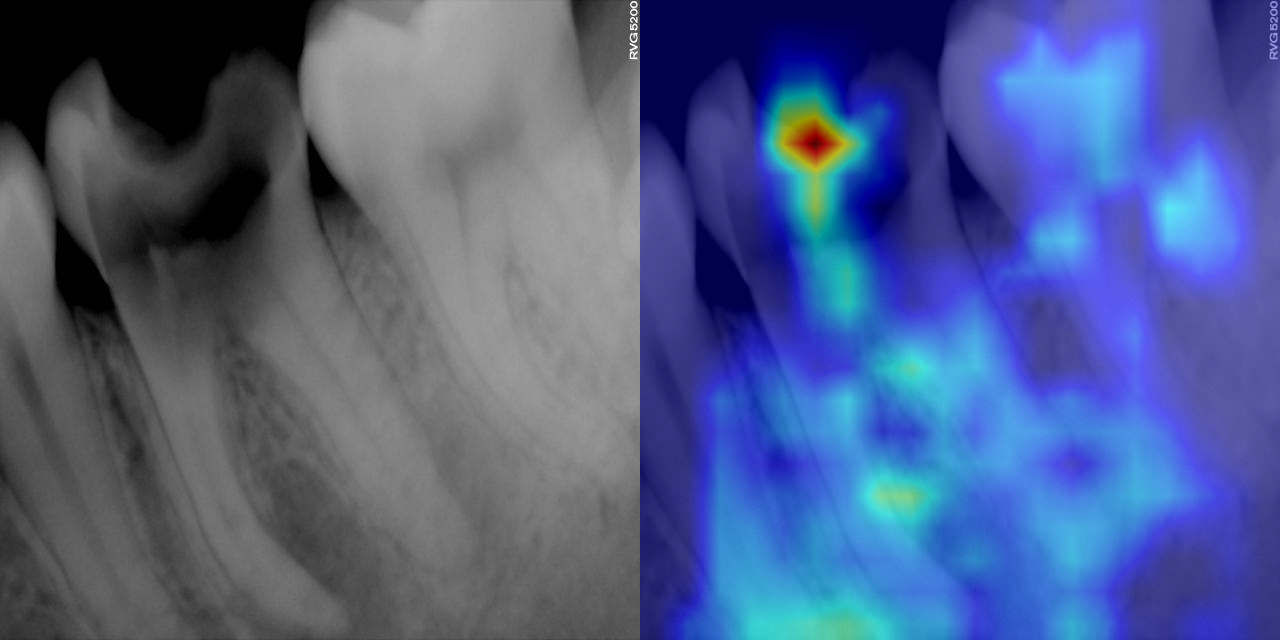

In [ ]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [ ]:
list_of_metrics = ["R_curve.png", "confusion_matrix.png", "results.png"]

In [ ]:
%cd /kaggle/working/

/kaggle/working


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


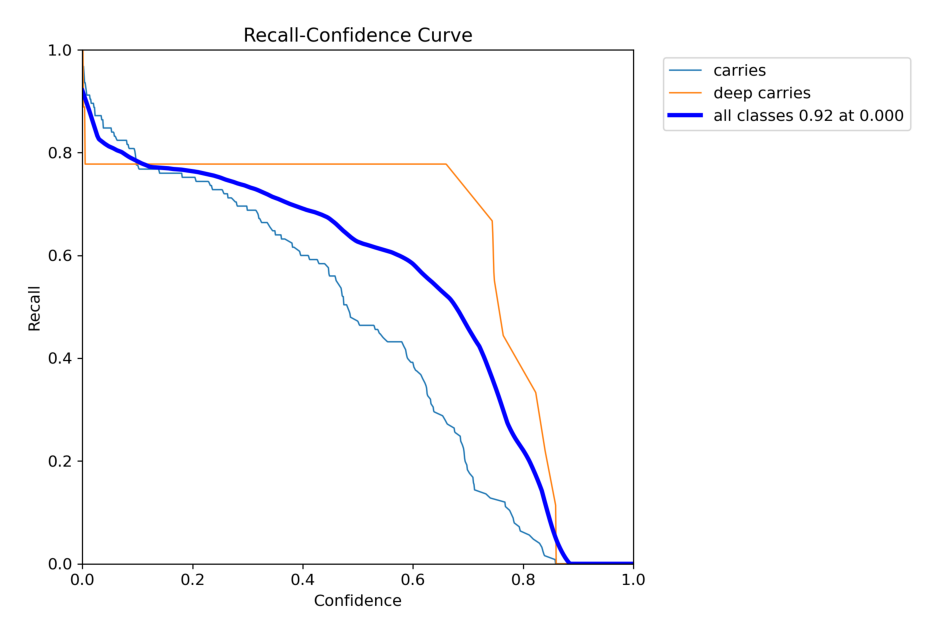

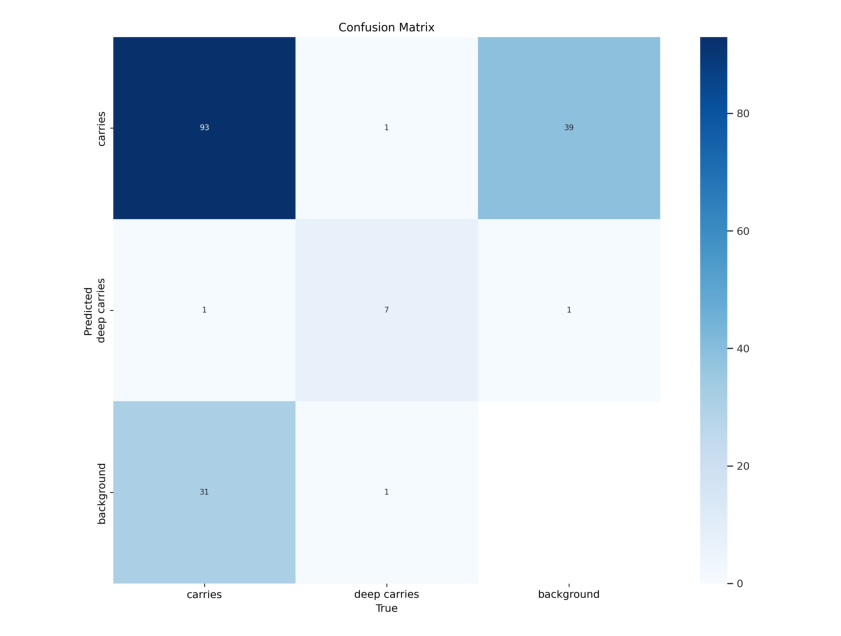

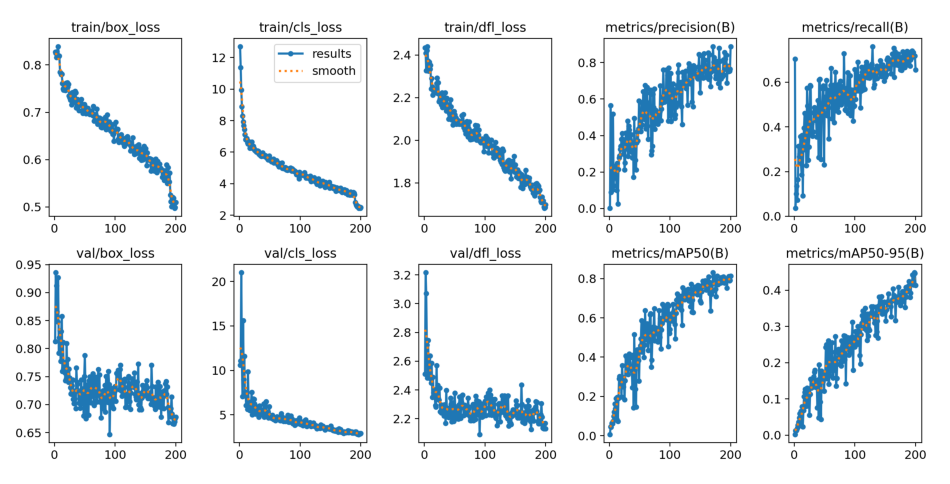

In [ ]:
from PIL import Image
for i in list_of_metrics:

    image = Image.open(f'{HOME}/runs/detect/caries_v1_aug/{i}')

    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()
